In [4]:
import scipy.cluster.hierarchy as sch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine
import seaborn as sns
import sklearn

In [5]:
#建立與 MySQL 的連結
class mysql_engine():
 def __init__(self,db):
  self.user='root'
  self.passwd='ian1991'
  self.host='localhost'
  self.port = '3306'
  self.db_name= db
  self.engine = create_engine('mysql+pymysql://{0}:{1}@{2}:{3}/{4}?charset=utf8'.format(self.user,self.passwd,self.host,self.port,self.db_name))

def get_data(sql,db):
 pg_enine = mysql_engine(db)
 try:
  with pg_enine.engine.connect() as con, con.begin():
   df = pd.read_sql(sql,con) # 獲取資料
  con.close()
 except:
  df = None
 return df

In [6]:
#取得需要的特徵:營收成長率, 稅後淨利率, 營業毛利率, 股東權益報酬率, 資產報酬率
company_factor = get_data("""SELECT stock_code,
                                    stock_report_date data_date,
                                    revenue_growth_rate,
                                    net_profit_rate,
                                    operating_gross_rate,
                                    roe_rate, 
                                    roa_rate
                             FROM datamining_alldata_afetl;""",'tfb103d_project')
company_factor

,stock_code,data_date,revenue_growth_rate,net_profit_rate,operating_gross_rate,roe_rate,roa_rate
0,2302,20183,17.77,13.35,38.03,1.07,0.91
1,2302,20184,-0.91,5.22,40.93,0.42,0.37
2,2302,20191,-6.33,-3.00,37.03,-0.20,-0.14
3,2302,20192,-2.46,10.26,32.10,0.85,0.74
4,2302,20193,-6.54,2.29,28.78,0.17,0.17
...,...,...,...,...,...,...,...
1783,8299,20202,10.95,10.91,24.76,4.01,2.97
1784,8299,20203,-3.71,15.41,22.61,6.07,4.61
1785,8299,20204,-2.52,29.47,23.05,11.76,8.79
1786,8299,20211,0.17,13.09,29.71,4.71,3.41


In [10]:
#建立負債比率變動率計算 function
def debt_rate_change(series):
    ans = []
    for i in range(len(series)):
        try:
            tmp = round(((series[i] - series[i-1])/series[i-1]),2)
            ans.append(tmp)
        except:
            tmp = None
            ans.append(tmp)
    return ans  

In [11]:
#建立負債比率變動率

companys = set(company_factor['stock_code'])
# companys =['2330','2303','2329','2330','2337','2338','2342','2344','2351','2363',
#             '2369','2379','2388','2401','2408','2434','2436','2441','2449','2451',
#             '2454','2458','2481','3006','3014','3016','3034','3035','3041','3054',
#             '3094','3189','3257','3413','3443','3450','3530','3532','3536','3545',
#             '3583','3588','3661','3686','3711','4919','4952','4961','4967','4968',
#             '5222','5269','5285','5471','6202','6239','6243','6257','6271','6415',
#             '6451','6515','6525','6531','6533','6552','6573','6756','8016','8028',
#             '8081','8110','8131','8150','8261','8271','3073','3105','3122','3141',
#             '3169','3227','3228','3259','3260','3264','3265','3268','3317','3372',
#             '3374','3438','3527','3529','3555','3556','3567','3581','3675','3680',
#             '3707','4945','4966','4971','4973','4991','5236','5272','5274','5299',
#             '5302','5314','5344','5347','5351','5425','5468','5483','5487','6104',
#             '6129','6138','6147','6182','6198','6223','6233','6237','6261','8299',
#             '6287','6291','6411','6435','6457','6462','6485','6488','6494','6510',
#             '6532','6548','6568','6594','6640','6643','6651','6679','6683','6684',
#             '6716','6732','6788','7556','8024','8040','8054','8086','8088','8277',
#              ]
df_dr_change = pd.DataFrame([],columns=['stock_code','data_date','debt_rate','debt_rate_change'])
i = 0
for company in companys:
    debt_rate_factor = get_data(f"""SELECT stock_code,
                                           stock_report_date data_date,
                                           debt_rate
                                     FROM finacial_statements
                                     WHERE stock_code = {company};""",'stock')  #負債比率
    debt_rate_factor.insert(3,"debt_rate_change",debt_rate_change(debt_rate_factor['debt_rate'])) #計算並插入負債變動率

    try:
        df_dr_change = df_dr_change.append(debt_rate_factor, ignore_index = True)
        i += 1
    except:
        print(company," ERROR!!")
        
print("total companys = ",i)
df_dr_change

total companys =  149


,stock_code,data_date,debt_rate,debt_rate_change
0,2481,20161,61.55,NaN
1,2481,20162,60.69,-0.01
2,2481,20163,60.09,-0.01
3,2481,20164,58.96,-0.02
4,2481,20171,58.46,-0.01
...,...,...,...,...
3229,8150,20202,45.11,-0.04
3230,8150,20203,41.22,-0.09
3231,8150,20204,40.62,-0.01
3232,8150,20211,41.36,0.02


In [12]:
data_df = pd.merge(company_factor, df_dr_change, on=["data_date",'stock_code'], how="inner")
data_df

,stock_code,data_date,revenue_growth_rate,net_profit_rate,operating_gross_rate,roe_rate,roa_rate,debt_rate,debt_rate_change
0,2302,20183,17.77,13.35,38.03,1.07,0.91,18.22,-0.09
1,2302,20184,-0.91,5.22,40.93,0.42,0.37,16.86,-0.07
2,2302,20191,-6.33,-3.00,37.03,-0.20,-0.14,16.38,-0.03
3,2302,20192,-2.46,10.26,32.10,0.85,0.74,16.63,0.02
4,2302,20193,-6.54,2.29,28.78,0.17,0.17,17.45,0.05
...,...,...,...,...,...,...,...,...,...
1759,8299,20202,10.95,10.91,24.76,4.01,2.97,27.74,0.08
1760,8299,20203,-3.71,15.41,22.61,6.07,4.61,23.66,-0.15
1761,8299,20204,-2.52,29.47,23.05,11.76,8.79,26.09,0.10
1762,8299,20211,0.17,13.09,29.71,4.71,3.41,29.32,0.12


<h2> 嘗試整理月營收資料為特徵

In [14]:
month_income = get_data("""SELECT stock_code,
                                  stock_report_date data_date,
                                operating_revenue_month
                             FROM operating_revenue_month;""",'stock')
month_income

,stock_code,data_date,operating_revenue_month
0,2302,201601,45.38
1,2302,201602,34.75
2,2302,201603,48.54
3,2302,201604,52.06
4,2302,201605,52.21
...,...,...,...
3569,6488,202104,4996.41
3570,6488,202105,4805.16
3571,6488,202106,5406.90
3572,6488,202107,4831.87


In [15]:
#建立負債比率變動率計算 function
def revenue_change(series):
    ans = []
    for i in range(len(series)):
        try:
            tmp = round(((series[i] - series[i-1])/series[i-1]),2)
            ans.append(tmp)
        except:
            tmp = None
            ans.append(tmp)
    return ans  

In [16]:
#建立營收成長變動率
companys = set(company_factor['stock_code'])

df_revenue_change = pd.DataFrame([],columns=['stock_code','data_date','operating_revenue_month','revenue_change_rate'])
i = 0
for company in companys:
    revenue_change_factor = get_data(f"""SELECT stock_code,
                                                stock_report_date data_date,
                                                operating_revenue_month
                                     FROM operating_revenue_month
                                     WHERE stock_code = {company};""",'stock')  #月營收
    revenue_change_factor.insert(3,"revenue_change_rate",revenue_change(revenue_change_factor['operating_revenue_month'])) 
    #計算並插入月營收成長率

    try:
        df_revenue_change = df_revenue_change.append(revenue_change_factor, ignore_index = True)
        i += 1
        
    except:
        print(company," ERROR!!")
        
print("total companys = ",i)
df_revenue_change

total companys =  149


,stock_code,data_date,operating_revenue_month,revenue_change_rate
0,2481,201601,1097.12,NaN
1,2481,201602,839.92,-0.23
2,2481,201603,1228.76,0.46
3,2481,201604,1108.16,-0.10
4,2481,201605,1180.76,0.07
...,...,...,...,...
3501,3545,202105,1950.43,0.02
3502,3545,202106,1913.16,-0.02
3503,3545,202107,2019.22,0.06
3504,3545,202108,2135.95,0.06


In [17]:
data_df.isnull().sum()

stock_code              0
data_date               0
revenue_growth_rate     0
net_profit_rate         0
operating_gross_rate    0
roe_rate                0
roa_rate                0
debt_rate               0
debt_rate_change        0
dtype: int64

In [18]:
#缺值處理
financial_ratio_nona = data_df.copy()

#刪除
financial_ratio_nona = financial_ratio_nona.dropna()

In [19]:
financial_ratio_nona.isnull().sum()

stock_code              0
data_date               0
revenue_growth_rate     0
net_profit_rate         0
operating_gross_rate    0
roe_rate                0
roa_rate                0
debt_rate               0
debt_rate_change        0
dtype: int64

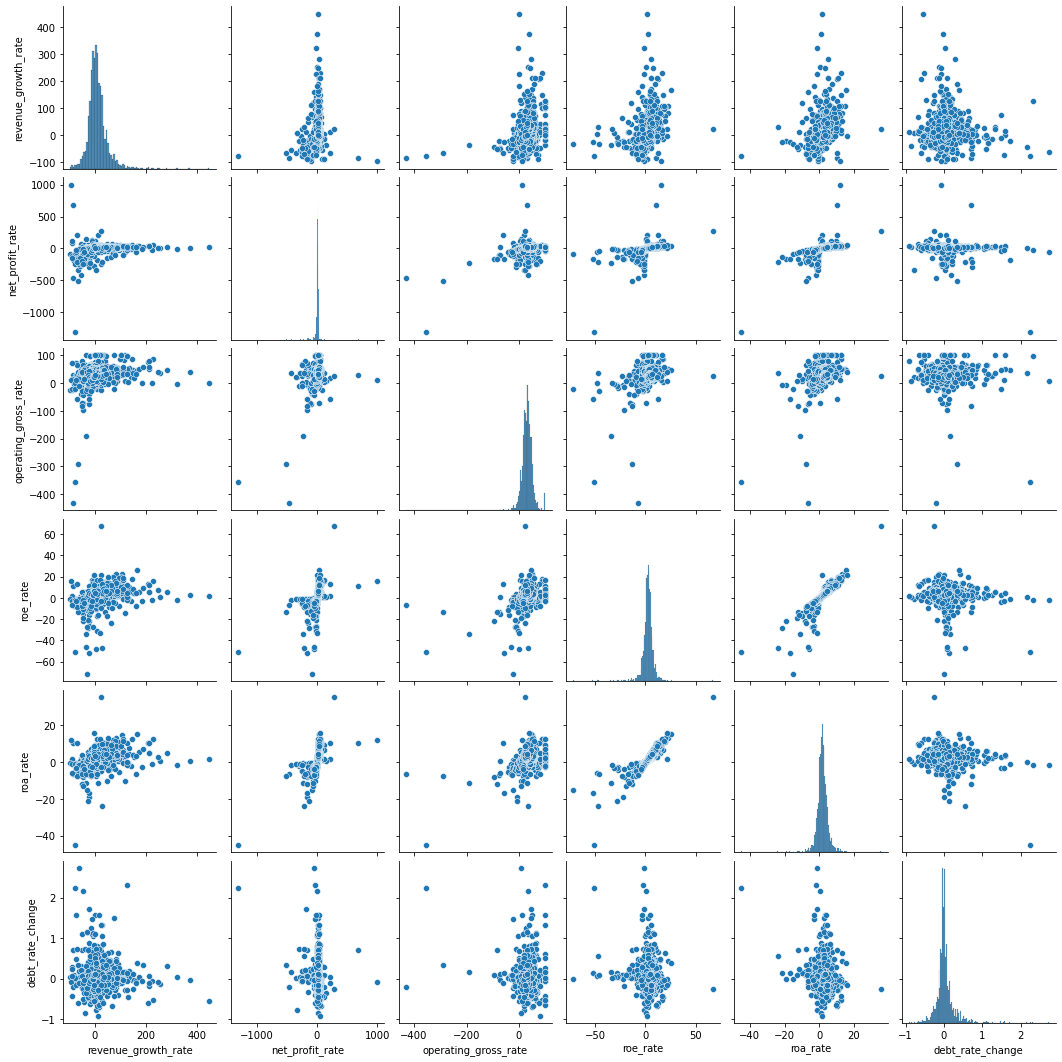

In [20]:
#觀察資料間的關係
compare_df = financial_ratio_nona.drop(['stock_code','data_date','debt_rate'], axis=1)
sns.pairplot(compare_df)

In [21]:
X0 = financial_ratio_nona[['revenue_growth_rate','net_profit_rate','operating_gross_rate']] #營收成長率、淨利率、毛利率
X1 = financial_ratio_nona[['revenue_growth_rate','roe_rate','roa_rate']] #營收成長率、ROA、ROE
X2 = financial_ratio_nona[['revenue_growth_rate','debt_rate_change','roa_rate']] #營收成長率、負債變動率、ROA
X3 = financial_ratio_nona[['operating_gross_rate','debt_rate_change','roa_rate']] #毛利率、負債變動率、ROA
X_all = financial_ratio_nona[['revenue_growth_rate','net_profit_rate','operating_gross_rate','roe_rate', 'roa_rate','debt_rate_change']]
X_all.iloc[:,0]

0       17.77
1       -0.91
2       -6.33
3       -2.46
4       -6.54
        ...  
1759    10.95
1760    -3.71
1761    -2.52
1762     0.17
1763    46.57
Name: revenue_growth_rate, Length: 1764, dtype: float64

In [22]:
# 輸入數據調成標準值以免各特徵影響不同
# you'll learn why scaling is needed in a later course
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled0 = scaler.fit_transform(X0)
X_scaled1 = scaler.fit_transform(X1)
X_scaled2 = scaler.fit_transform(X2)
X_scaled3 = scaler.fit_transform(X3)
X_scaled_all = scaler.fit_transform(X_all)
print(X_scaled_all.max())
print(X_scaled_all.min())
X_scaled_all.std()

16.679199322519977
-22.06796785804423


0.9999999999999999

In [23]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons
from sklearn.metrics import adjusted_rand_score

In [24]:
#建立 DBSCAN 模型
dbscan0 = DBSCAN(eps=0.65, min_samples = 6)
dbscan0.fit(X_scaled0)
dbscan1 = DBSCAN(eps=0.65, min_samples = 6)
dbscan1.fit(X_scaled1)
dbscan2 = DBSCAN(eps=0.65, min_samples = 6)
dbscan2.fit(X_scaled2)
dbscan3 = DBSCAN(eps=0.8, min_samples = 8)
dbscan3.fit(X_scaled3)
dbscan_all = DBSCAN(eps=0.5, min_samples = 6)
dbscan_all.fit(X_scaled_all)

DBSCAN(min_samples=6)

In [25]:
#檢視分群群數
print(set(dbscan0.labels_))
print(set(dbscan1.labels_))
print(set(dbscan2.labels_))
print(set(dbscan3.labels_))
print(set(dbscan_all.labels_))

{0, 1, 2, -1}
{0, -1}
{0, -1}
{0, 1, -1}
{0, 1, 2, 3, -1}


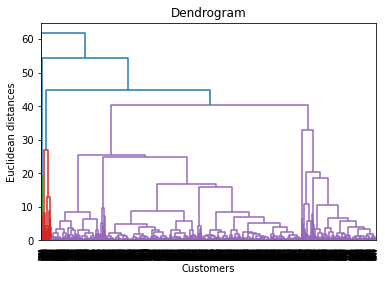

In [80]:
dendrogram0 = sch.dendrogram(sch.linkage(X_scaled0, method  = "ward"))
plt.rcParams["figure.figsize"] = (16, 16)
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

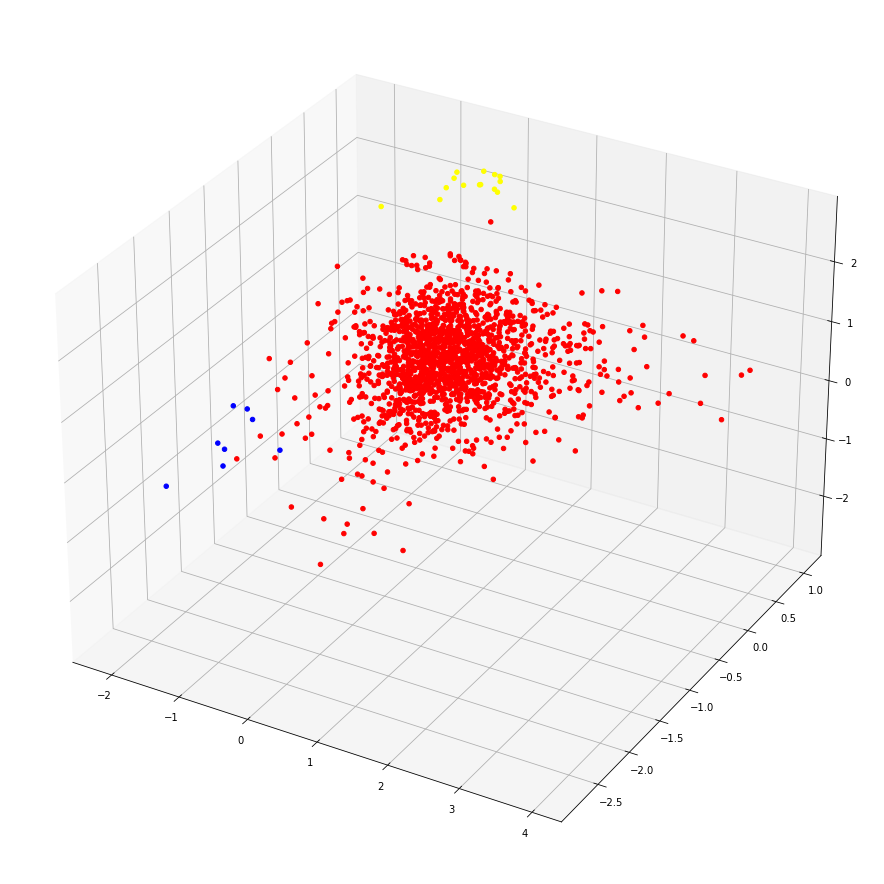

In [46]:
fig0 = plt.figure(figsize=(16,16))
ax4 = plt.axes(projection='3d')
ax4.scatter(X_scaled0[dbscan0.labels_==0, 0],X_scaled0[dbscan0.labels_==0, 1],X_scaled0[dbscan0.labels_==0, 2],alpha=1,c="red")
# ax4.scatter(X_scaled0[dbscan0.labels_==-1, 0],X_scaled0[dbscan0.labels_==-1, 1],X_scaled0[dbscan0.labels_==-1, 2],alpha=1,c="green")
ax4.scatter(X_scaled0[dbscan0.labels_==1, 0],X_scaled0[dbscan0.labels_==1, 1],X_scaled0[dbscan0.labels_==1, 2],alpha=1,c="blue")
ax4.scatter(X_scaled0[dbscan0.labels_==2, 0],X_scaled0[dbscan0.labels_==2, 1],X_scaled0[dbscan0.labels_==2, 2],alpha=1,c="yellow")
plt.show()

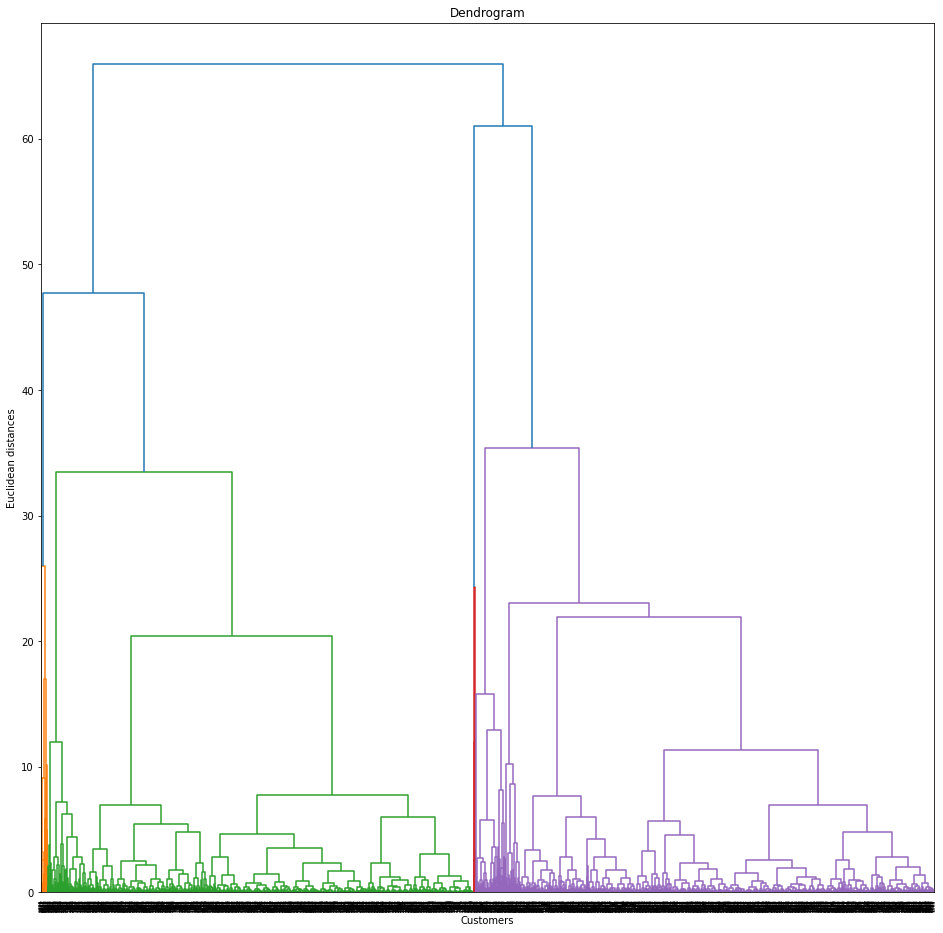

In [114]:
dendrogram1 = sch.dendrogram(sch.linkage(X_scaled1, method  = "ward"))
plt.rcParams["figure.figsize"] = (16, 16)
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

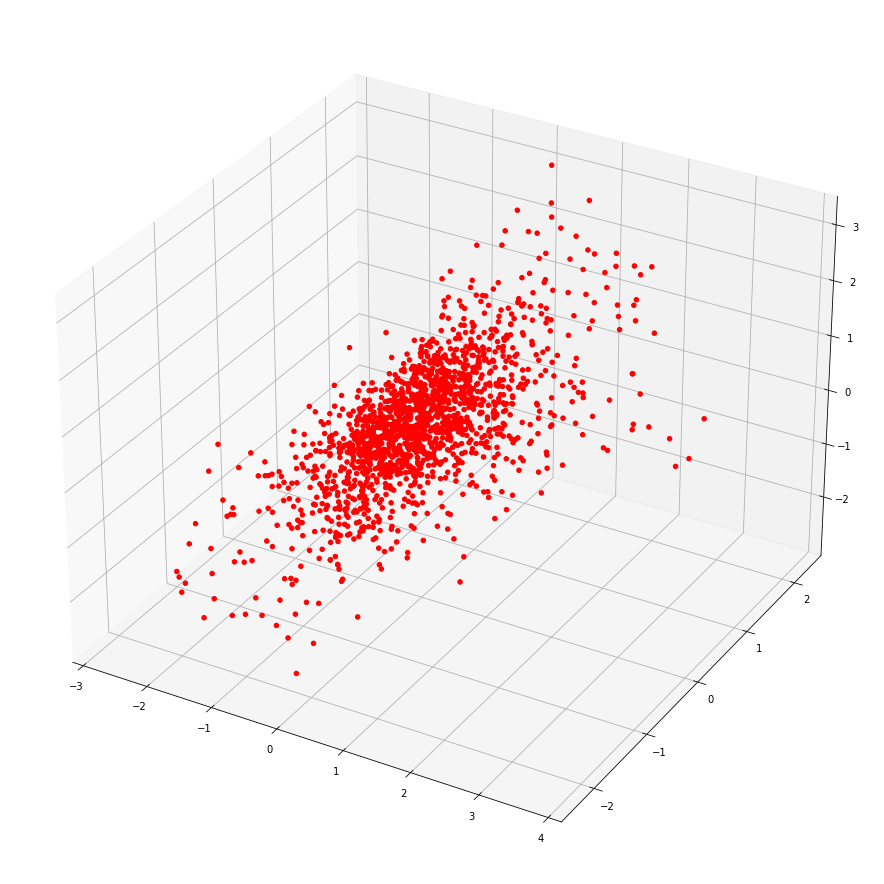

In [45]:
fig1 = plt.figure(figsize=(16,16))
ax4 = plt.axes(projection='3d')
ax4.scatter(X_scaled1[dbscan1.labels_==0, 0],X_scaled1[dbscan1.labels_==0, 1],X_scaled1[dbscan1.labels_==0, 2],alpha=1,c="red")
# ax4.scatter(X_scaled1[dbscan1.labels_==-1, 0],X_scaled1[dbscan1.labels_==-1, 1],X_scaled1[dbscan1.labels_==-1, 2],alpha=1,c="green")
ax4.scatter(X_scaled1[dbscan1.labels_==1, 0],X_scaled1[dbscan1.labels_==1, 1],X_scaled1[dbscan1.labels_==1, 2],alpha=1,c="blue")
ax4.scatter(X_scaled1[dbscan1.labels_==2, 0],X_scaled1[dbscan1.labels_==2, 1],X_scaled1[dbscan1.labels_==2, 2],alpha=1,c="yellow")
plt.show()

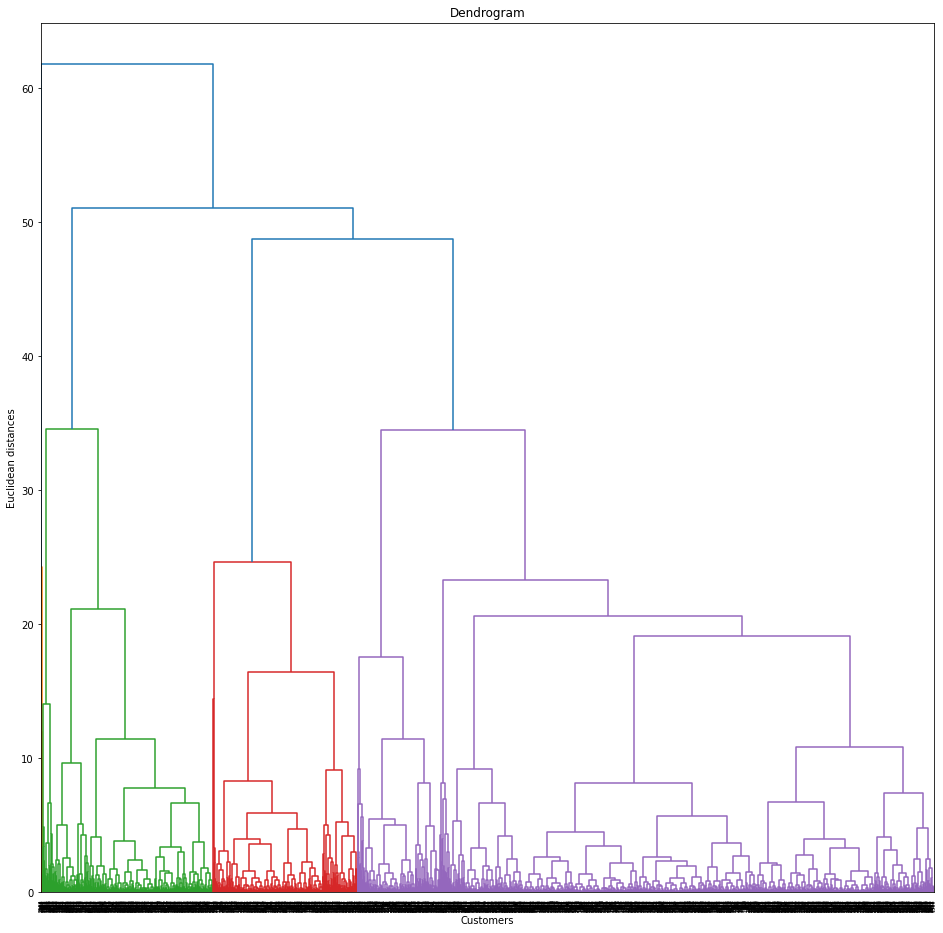

In [82]:
dendrogram2 = sch.dendrogram(sch.linkage(X_scaled2, method  = "ward"))
plt.rcParams["figure.figsize"] = (16, 16)
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

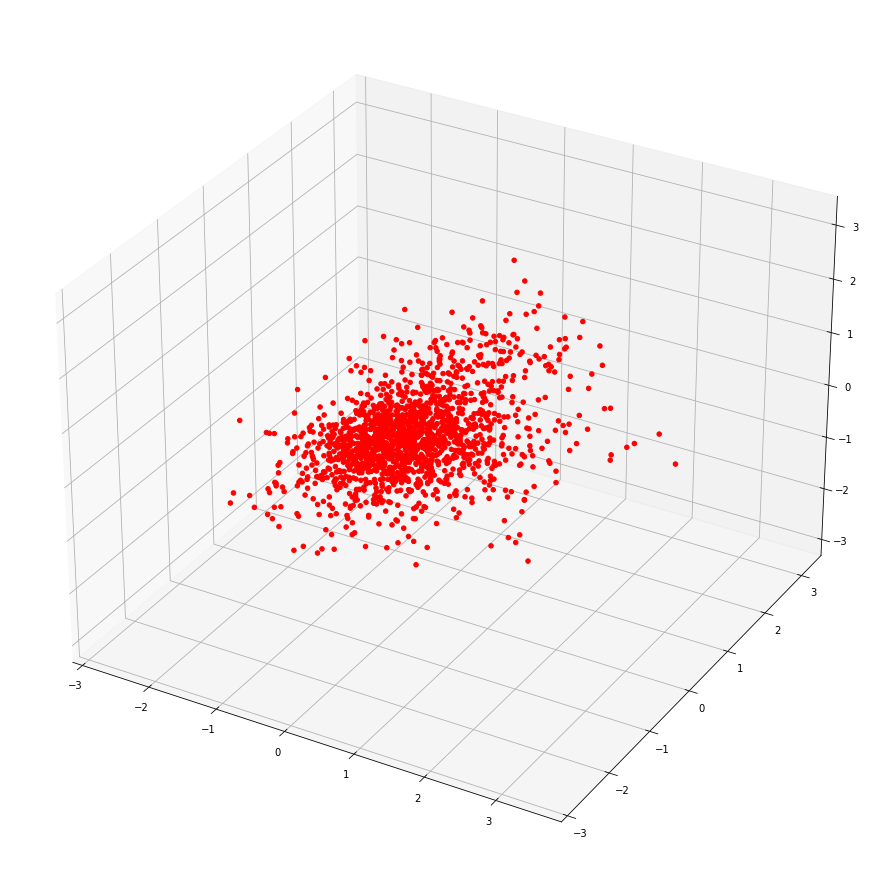

In [44]:
fig2 = plt.figure(figsize=(16,16))
ax4 = plt.axes(projection='3d')
ax4.scatter(X_scaled2[dbscan2.labels_==0, 0],X_scaled2[dbscan2.labels_==0, 1],X_scaled2[dbscan2.labels_==0, 2],alpha=1,c="red")
# ax4.scatter(X_scaled2[dbscan2.labels_==-1, 0],X_scaled2[dbscan2.labels_==-1, 1],X_scaled2[dbscan2.labels_==-1, 2],alpha=1,c="green")
ax4.scatter(X_scaled2[dbscan2.labels_==1, 0],X_scaled2[dbscan2.labels_==1, 1],X_scaled2[dbscan2.labels_==1, 2],alpha=1,c="blue")
ax4.scatter(X_scaled2[dbscan2.labels_==2, 0],X_scaled2[dbscan2.labels_==2, 1],X_scaled2[dbscan2.labels_==2, 2],alpha=1,c="yellow")
ax4.scatter(X_scaled2[dbscan2.labels_==3, 0],X_scaled2[dbscan2.labels_==3, 1],X_scaled2[dbscan2.labels_==3, 2],alpha=1,c="orange")
plt.show()

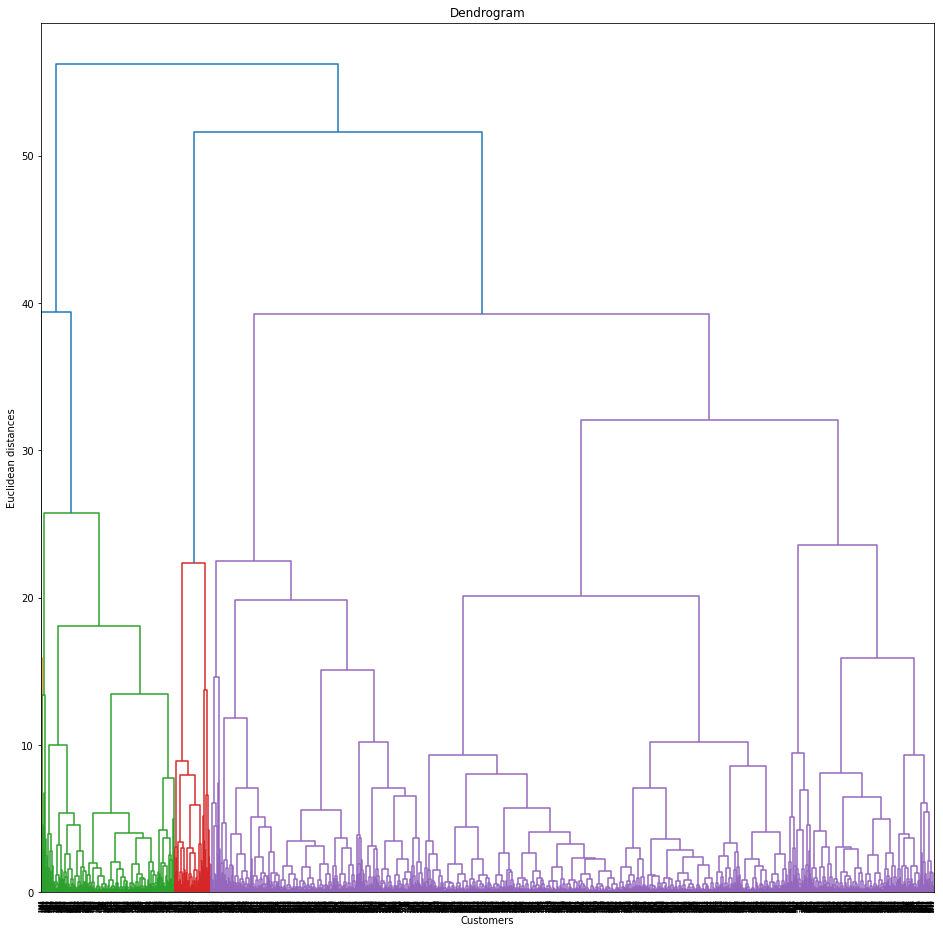

In [92]:
dendrogram3 = sch.dendrogram(sch.linkage(X_scaled3, method  = "ward"))
plt.rcParams["figure.figsize"] = (16, 16)
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

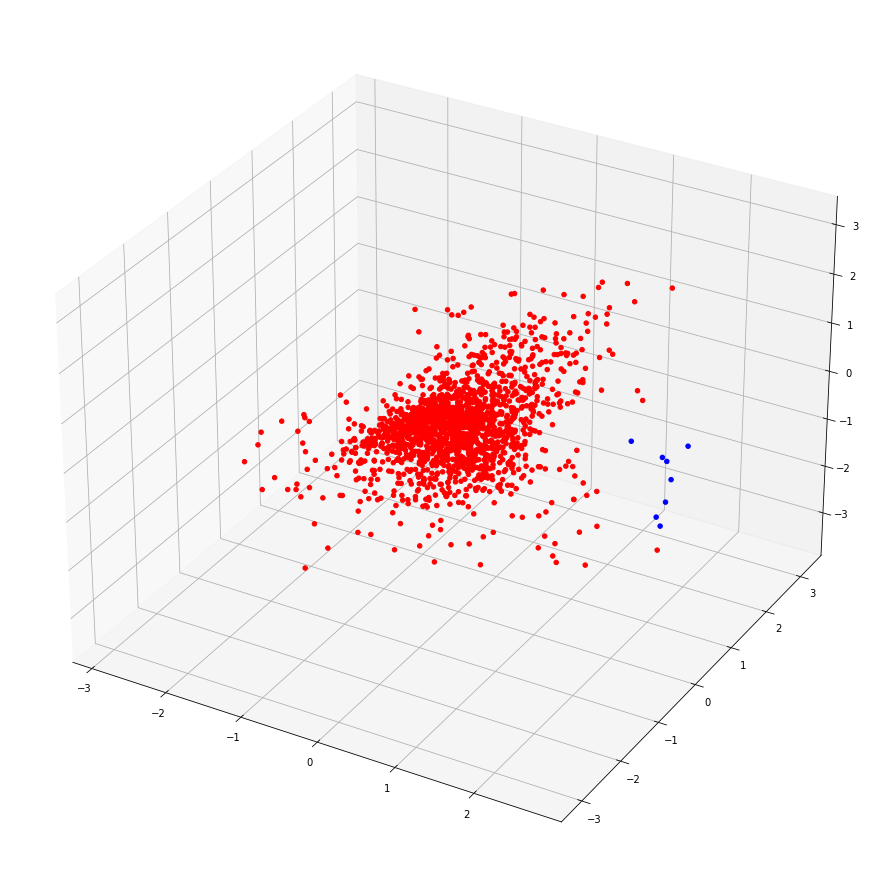

In [43]:
fig3 = plt.figure(figsize=(16,16))
ax4 = plt.axes(projection='3d')
ax4.scatter(X_scaled3[dbscan3.labels_==0, 0],X_scaled3[dbscan3.labels_==0, 1],X_scaled3[dbscan3.labels_==0, 2],alpha=1,c="red")
# ax4.scatter(X_scaled3[dbscan3.labels_==-1, 0],X_scaled3[dbscan3.labels_==-1, 1],X_scaled3[dbscan3.labels_==-1, 2],alpha=1,c="green")
ax4.scatter(X_scaled3[dbscan3.labels_==1, 0],X_scaled3[dbscan3.labels_==1, 1],X_scaled3[dbscan3.labels_==1, 2],alpha=1,c="blue")
ax4.scatter(X_scaled3[dbscan3.labels_==2, 0],X_scaled3[dbscan3.labels_==2, 1],X_scaled3[dbscan3.labels_==2, 2],alpha=1,c="yellow")
ax4.scatter(X_scaled3[dbscan3.labels_==3, 0],X_scaled3[dbscan3.labels_==3, 1],X_scaled3[dbscan3.labels_==3, 2],alpha=1,c="purple")
ax4.scatter(X_scaled3[dbscan3.labels_==4, 0],X_scaled3[dbscan3.labels_==4, 1],X_scaled3[dbscan3.labels_==4, 2],alpha=1,c="orange")
ax4.scatter(X_scaled3[dbscan3.labels_==5, 0],X_scaled3[dbscan3.labels_==5, 1],X_scaled3[dbscan3.labels_==5, 2],alpha=1,c="green")
plt.show()

In [29]:
from sklearn import decomposition
from sklearn import datasets
pca = decomposition.PCA(n_components=3)

In [30]:
pca.fit(X_scaled_all)
X_scaled_all = pca.transform(X_scaled_all)

In [31]:
dbscan_all.labels_

array([ 0,  0,  0, ..., -1,  0,  1], dtype=int64)

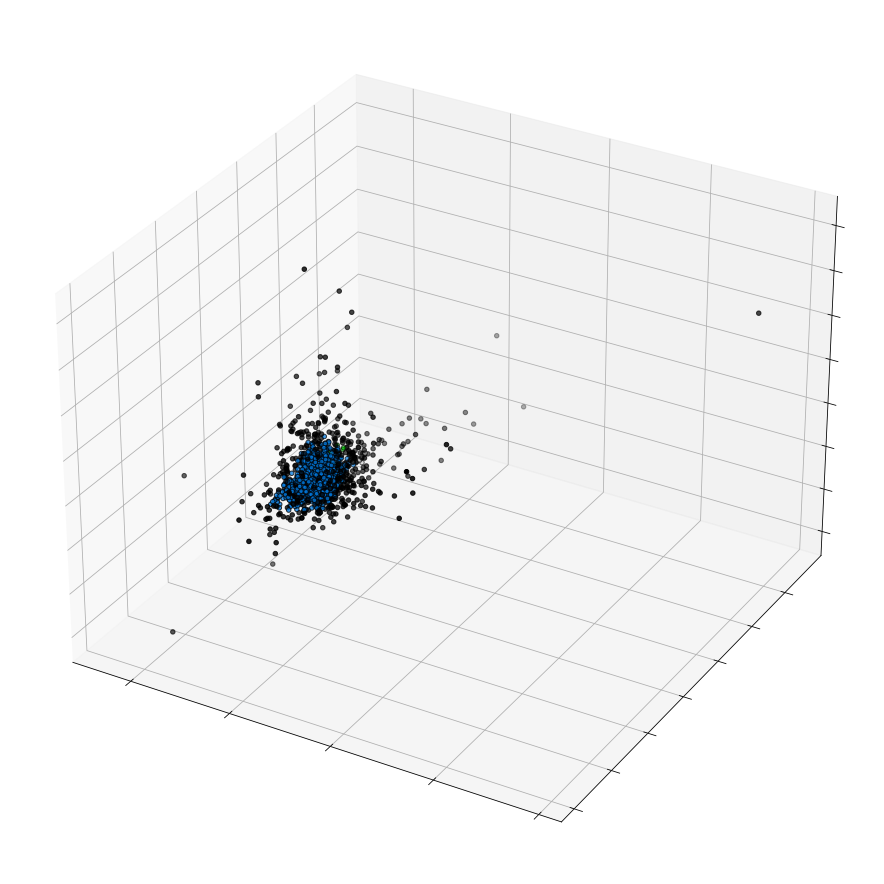

In [42]:
# y = np.choose(dbscan_all.labels_, [1, 2, 0]).astype(np.float)
fig3 = plt.figure(figsize=(16,16))
ax4 = plt.axes(projection='3d')
ax4.scatter(X_scaled_all[:, 0], X_scaled_all[:, 1], X_scaled_all[:, 2], c=dbscan_all.labels_, cmap=plt.cm.nipy_spectral,
           edgecolor='k')
ax4.w_xaxis.set_ticklabels([])
ax4.w_yaxis.set_ticklabels([])
ax4.w_zaxis.set_ticklabels([])

plt.show()
# ax4.scatter(X_scaled_all[dbscan3.labels_==0, 0],X_scaled_all[dbscan3.labels_==0, 1],X_scaled_all[dbscan3.labels_==0, 2],alpha=1,c="red")
# # ax4.scatter(X_scaled_all[dbscan3.labels_==-1, 0],X_scaled_all[dbscan3.labels_==-1, 1],X_scaled_all[dbscan3.labels_==-1, 2],alpha=1,c="green")
# ax4.scatter(X_scaled_all[dbscan3.labels_==1, 0],X_scaled_all[dbscan3.labels_==1, 1],X_scaled_all[dbscan3.labels_==1, 2],alpha=1,c="blue")
# ax4.scatter(X_scaled_all[dbscan3.labels_==2, 0],X_scaled_all[dbscan3.labels_==2, 1],X_scaled_all[dbscan3.labels_==2, 2],alpha=1,c="yellow")
# ax4.scatter(X_scaled_all[dbscan3.labels_==3, 0],X_scaled_all[dbscan3.labels_==3, 1],X_scaled_all[dbscan3.labels_==3, 2],alpha=1,c="purple")
# ax4.scatter(X_scaled_all[dbscan3.labels_==4, 0],X_scaled_all[dbscan3.labels_==4, 1],X_scaled_all[dbscan3.labels_==4, 2],alpha=1,c="orange")
# ax4.scatter(X_scaled_all[dbscan3.labels_==5, 0],X_scaled_all[dbscan3.labels_==5, 1],X_scaled_all[dbscan3.labels_==5, 2],alpha=1,c="green")
# plt.show()

In [33]:
#將分群結果插入dataFrame
financial_ratio_nona.shape
financial_ratio_nona.insert(9,"label_1",dbscan0.labels_)
financial_ratio_nona.insert(10,"label_2",dbscan3.labels_)
financial_ratio_nona.insert(11,"label_all",dbscan_all.labels_)
financial_ratio_nona

,stock_code,data_date,revenue_growth_rate,net_profit_rate,operating_gross_rate,roe_rate,roa_rate,debt_rate,debt_rate_change,label_1,label_2,label_all
0,2302,20183,17.77,13.35,38.03,1.07,0.91,18.22,-0.09,0,0,0
1,2302,20184,-0.91,5.22,40.93,0.42,0.37,16.86,-0.07,0,0,0
2,2302,20191,-6.33,-3.00,37.03,-0.20,-0.14,16.38,-0.03,0,0,0
3,2302,20192,-2.46,10.26,32.10,0.85,0.74,16.63,0.02,0,0,0
4,2302,20193,-6.54,2.29,28.78,0.17,0.17,17.45,0.05,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1759,8299,20202,10.95,10.91,24.76,4.01,2.97,27.74,0.08,0,0,0
1760,8299,20203,-3.71,15.41,22.61,6.07,4.61,23.66,-0.15,0,0,0
1761,8299,20204,-2.52,29.47,23.05,11.76,8.79,26.09,0.10,0,0,-1
1762,8299,20211,0.17,13.09,29.71,4.71,3.41,29.32,0.12,0,0,0


In [34]:
#以營收成長率、淨利率、毛利率分群 label 為 1 者
financial_ratio_nona.loc[financial_ratio_nona.label_1 > 0]  #營收成長率、淨利率、毛利率

,stock_code,data_date,revenue_growth_rate,net_profit_rate,operating_gross_rate,roe_rate,roa_rate,debt_rate,debt_rate_change,label_1,label_2,label_all
123,2363,20192,-18.27,-150.89,41.88,-1.40,-1.38,1.03,0.03,1,0,-1
997,5302,20184,-33.56,-102.90,39.12,-1.04,-0.85,14.43,0.03,1,0,-1
998,5302,20191,-42.81,-93.87,38.09,-0.81,-0.64,14.88,0.03,1,0,-1
999,5302,20192,-34.32,-117.94,50.85,-1.03,-0.83,15.73,0.06,1,0,-1
1000,5302,20193,-34.93,-131.01,39.94,-1.13,-0.91,16.50,0.05,1,0,-1
1004,5302,20203,-34.73,-125.77,35.22,-0.74,-0.56,18.76,0.04,1,0,-1
1013,5314,20194,-42.94,-163.64,33.00,-7.35,-6.75,10.12,0.05,1,0,-1
1069,5468,20184,-15.24,-106.58,31.28,-12.28,-7.61,40.74,0.18,1,0,-1
1464,6533,20183,-16.07,-11.90,99.74,-0.58,-0.57,3.36,-0.02,2,1,-1
1469,6533,20194,6.03,7.76,99.92,0.87,0.83,15.51,0.01,2,1,-1


In [35]:
print(financial_ratio_nona.loc[financial_ratio_nona.label_1 > 0].shape)

(23, 12)


In [36]:
#以毛利率、負債變動率、ROA分群 label 為 1 者
financial_ratio_nona.loc[financial_ratio_nona.label_2 > 0] #毛利率、負債變動率、ROA

,stock_code,data_date,revenue_growth_rate,net_profit_rate,operating_gross_rate,roe_rate,roa_rate,debt_rate,debt_rate_change,label_1,label_2,label_all
476,3228,20203,114.93,17.92,83.35,4.01,3.02,30.51,0.12,-1,1,-1
1464,6533,20183,-16.07,-11.90,99.74,-0.58,-0.57,3.36,-0.02,2,1,-1
1465,6533,20184,120.26,31.90,99.96,3.42,3.31,3.89,0.16,-1,1,-1
1468,6533,20193,126.83,3.19,99.75,0.35,0.35,15.42,-0.05,-1,1,-1
1469,6533,20194,6.03,7.76,99.92,0.87,0.83,15.51,0.01,2,1,-1
1474,6533,20211,42.76,18.31,99.72,2.32,2.00,15.56,0.05,2,1,-1
1475,6533,20212,103.71,28.99,99.90,4.92,4.21,15.18,-0.02,-1,1,-1
1554,6643,20201,15.37,30.29,100.00,4.06,3.66,9.95,0.01,2,1,-1


In [37]:
financial_ratio_nona.loc[financial_ratio_nona.label_2 > 0].shape

(8, 12)

In [38]:
#以營收成長率, 稅後淨利率, 營業毛利率, 股東權益報酬率, 資產報酬率分群, 負債變動率 label 大於 1 者
financial_ratio_nona.loc[financial_ratio_nona.label_all > 0]  

,stock_code,data_date,revenue_growth_rate,net_profit_rate,operating_gross_rate,roe_rate,roa_rate,debt_rate,debt_rate_change,label_1,label_2,label_all
215,2436,20212,35.45,22.34,29.81,6.08,4.39,29.98,0.43,0,0,1
219,2441,20192,-7.34,16.42,24.61,3.06,2.53,20.58,0.64,0,0,3
250,2451,20211,8.64,15.99,24.38,3.06,2.65,16.62,0.67,0,0,3
327,3034,20192,22.92,13.05,32.05,7.15,4.31,43.01,0.25,0,0,1
331,3034,20202,14.14,13.74,33.48,7.92,5.05,42.20,0.31,0,0,1
333,3034,20204,35.87,16.23,38.03,9.98,6.95,31.25,0.03,0,0,2
655,3532,20202,8.28,11.03,20.79,1.70,1.49,14.29,0.58,0,0,3
987,5299,20192,23.13,17.12,32.35,7.62,4.96,38.44,0.30,0,0,1
1150,6138,20211,30.84,13.51,30.98,7.60,4.88,41.17,0.36,0,0,1
1275,6271,20192,3.54,10.55,21.50,1.90,1.54,23.58,0.56,0,0,3


In [39]:
financial_ratio_nona.loc[financial_ratio_nona.label_all > 0].shape

(19, 12)